In [1]:
import sys
sys.path.append('../scripts')
import pandas as pd
import proplot as pplt
import os
from helpers import *

In [6]:
%run ../scripts/process_stations.py

107 106
31 31
73 73
306 306
301 301
303 303
290 290
306 305
101 101
312 310
311 310
202 202
309 307
26 25
348 347
212 212
325 324
373 373
294 295
379 378
220 220
341 341
324 324
323 322
328 327
178 194
313 314
307 306
212 212
385 386
324 323
242 239
427 427
231 233
9 10
322 324
385 383
304 303
456 452
207 208
303 303
72 70
343 345
348 347
330 330
197 195
340 342
31 30
325 326
352 352
409 406
357 356
83 82
603 601
506 506
312 312
498 498
116 115
499 498
592 592
398 396
112 119
192 191
108 107
73 92
318 315
219 221
396 394
243 244
439 437
395 392
603 603
215 216
351 351
583 583
396 396
327 326
227 226
144 129
161 143
143 128
60 61
274 276
431 432
432 429
196 196
432 432
329 331
330 331
153 149
284 285
211 212
233 234
293 293
193 193
49 50
131 130
127 128
107 108
78 79
83 83
203 202
264 263
189 188
153 152
79 78
69 69
114 114
264 263
258 257
254 253
254 253
210 209
232 231
259 258
259 258
207 206
154 153
96 95
260 259
272 274
277 278
276 277
191 193
263 264
254 254
249 249
243 243
201 201

/opt/miniconda3/envs/airsea/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/opt/miniconda3/envs/airsea/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/airsea/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/airsea/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/airsea/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/miniconda3/envs/airsea/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invali

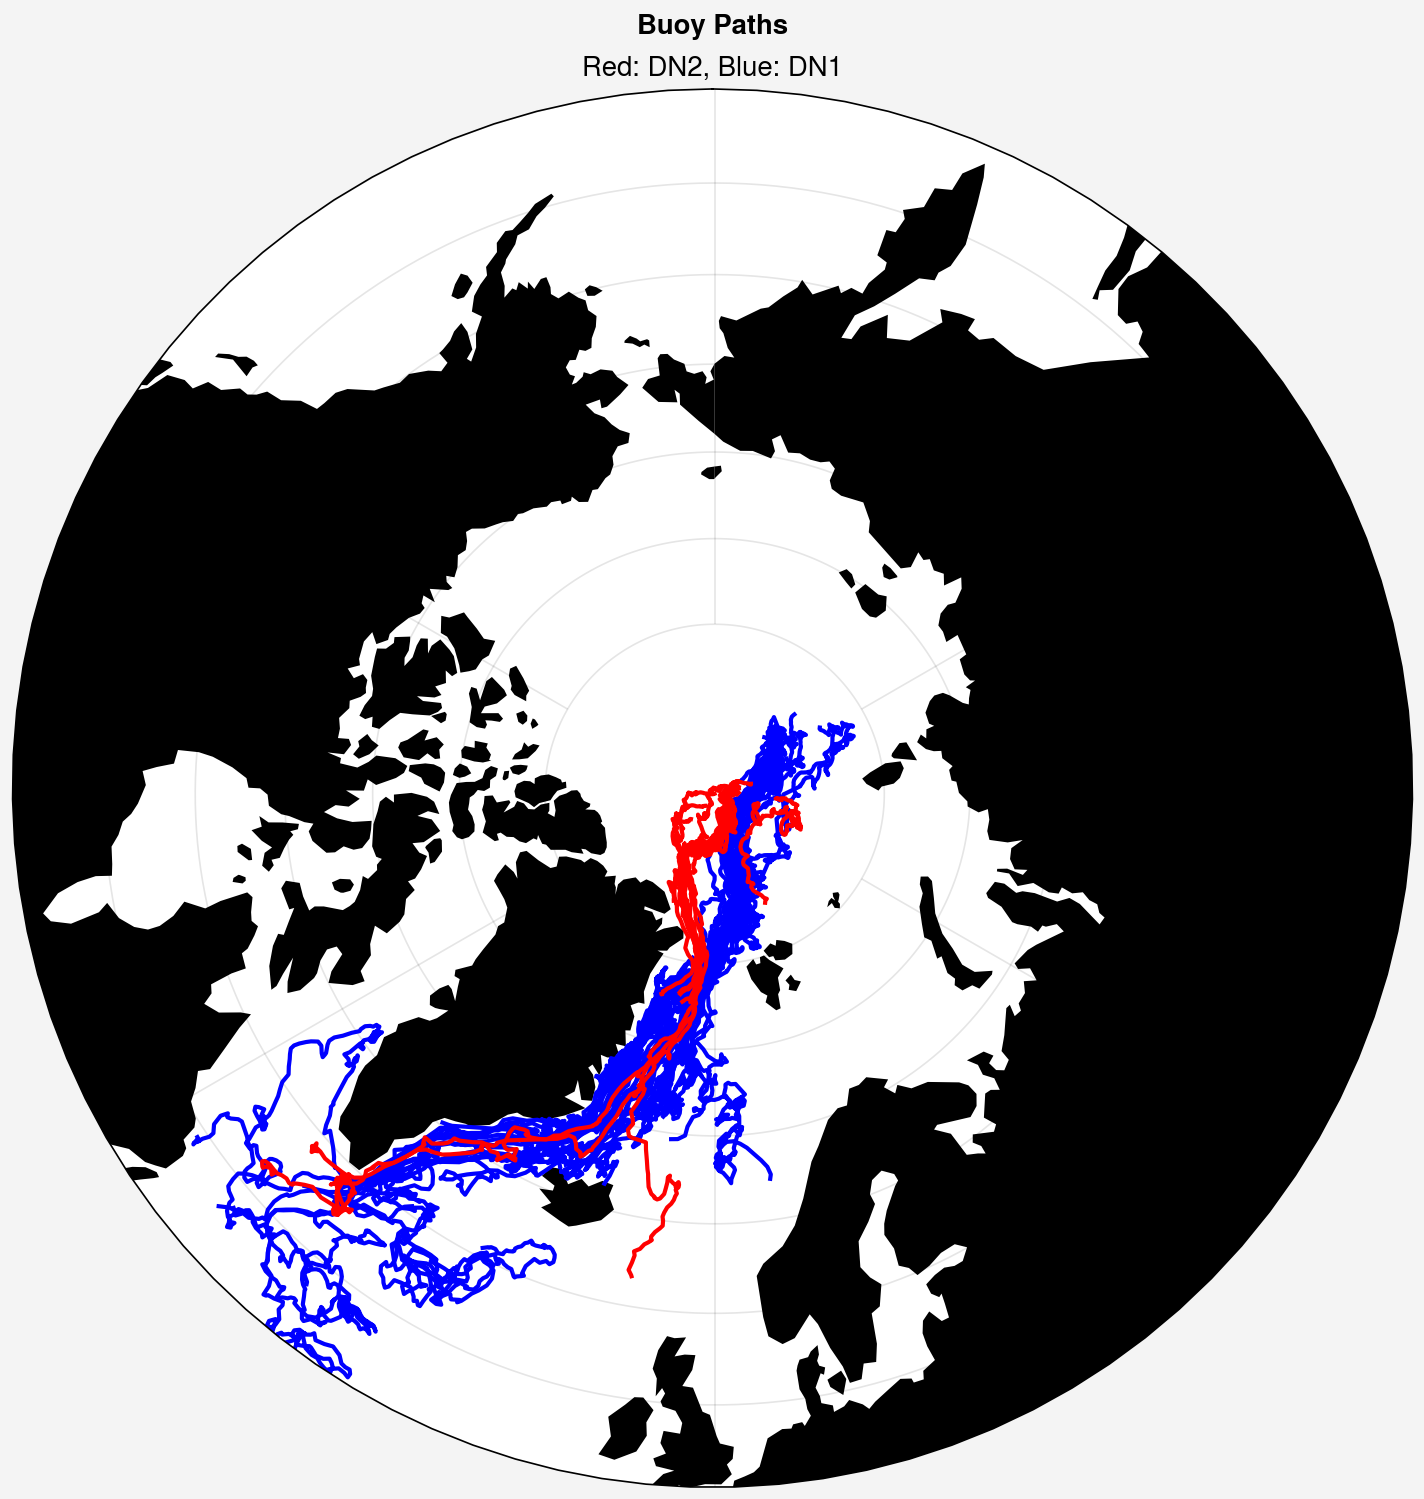

In [2]:
# Pole-centered map projections

fig, axs = pplt.subplots(ncols=1, refwidth=7, proj=('npstere'))
fig.format(suptitle='Buoy Paths')
axs.format(land=True)

dn1 = os.listdir("../data/daily_stations/mosaic_dn1")
dn2 = os.listdir("../data/daily_stations/mosaic_dn2")

axs[0].format(boundinglat=50, title='Red: DN2, Blue: DN1')

# Plot dn2 buoys in red, dn1 buoys in blue
for station in [i[:-4] for i in dn1]:
   axs[0].plot(station_data(station)['longitude'], station_data(station)['latitude'], color="blue")
for station in [i[:-4] for i in dn2]:
    axs[0].plot(station_data(station)['longitude'], station_data(station)['latitude'], color="red")

In [3]:
from icedrift.interpolation import sic_along_track

In [4]:
sic_loc = '../data/amsr2_sea_ice_concentration.nc'

In [7]:
import xarray as xr
ds = xr.open_dataset(sic_loc)
sic_along_track(station_data(station).set_index('datetime'), ds)

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [8]:
ds

<xarray.Dataset>
Dimensions:                (y: 448, x: 304, time: 155)
Coordinates:
  * time                   (time) datetime64[ns] 2020-04-30 ... 2020-10-01
  * x                      (x) float64 -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                      (y) float64 5.838e+06 5.812e+06 ... -5.338e+06
Data variables:
    latitude               (y, x) float64 ...
    longitude              (y, x) float64 ...
    sea_ice_concentration  (time, y, x) int32 ...
Attributes:
    sea_ice_concentration:  0: Open Water\n110: Missing\n120: Land\n1-100: Se...
    crs:                    NSIDC Polar Stereographic North Pole 25 km